<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Crude_PalmOil_Price_Prediction_SARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Load Basic Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
from pandas import read_csv
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

import matplotlib 
import scipy 
import sklearn

In [4]:
#Applying configurations for the quality of the image
plt.rcParams["figure.figsize"] = [12, 5]            
#plt.rcParams['figure.dpi'] = 100                  
plt.rc('font', size=8)                             
plt.rc('axes', titlesize=14)                       
plt.rc('axes', labelsize=14)                       
plt.rc('xtick', labelsize=10)                      
plt.rc('ytick', labelsize=10)                      
plt.rc('legend', fontsize=10)                      


In [40]:
#Load the data
path = 'https://raw.githubusercontent.com/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/main/Data/data.csv'
df = read_csv(path,index_col='Month', parse_dates=True)
df.head()

,Price,Change
Month,,
1993-03-01,408,-
1993-04-01,392,-3.92%
1993-05-01,371,-5.36%
1993-06-01,356,-4.04%
1993-07-01,362,1.69%


In [41]:
#Delete change column
del df['Change']

In [42]:
df.shape
df.dtypes

Price    object
dtype: object

In [43]:
#Remove the commas from the data
df["Price"] = [float(str(i).replace(",", "")) for i in df["Price"]]

df.dtypes

Price    float64
dtype: object

<Axes: title={'center': 'Monthly Crude Palm Oil Prediction'}, xlabel='Month'>

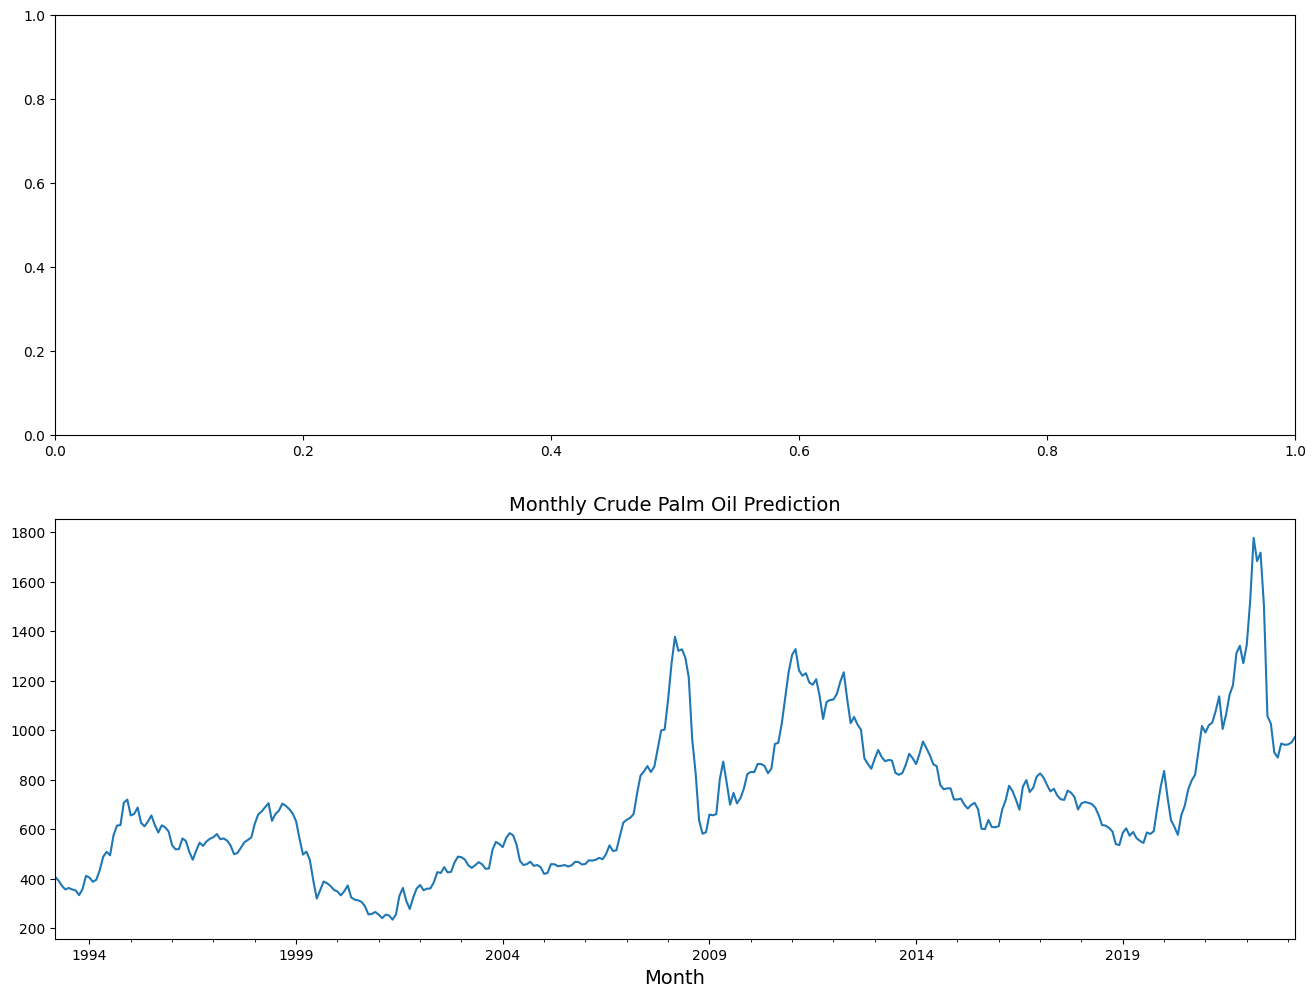

In [44]:
fig, ax = plt.subplots(2,1, figsize=(16, 12))
df.plot(title='Monthly Crude Palm Oil Prediction', legend=False, ax=ax[1])

In [45]:
#Splitting the data

def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [47]:
test_split = 0.15
df_train, df_test = split_data(df, test_split)

train: 307 , test: 54


In [48]:
#Checking for stationarity
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [49]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [50]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

In [51]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

###Plotting the ACF and PACF

<Axes: xlabel='Month'>

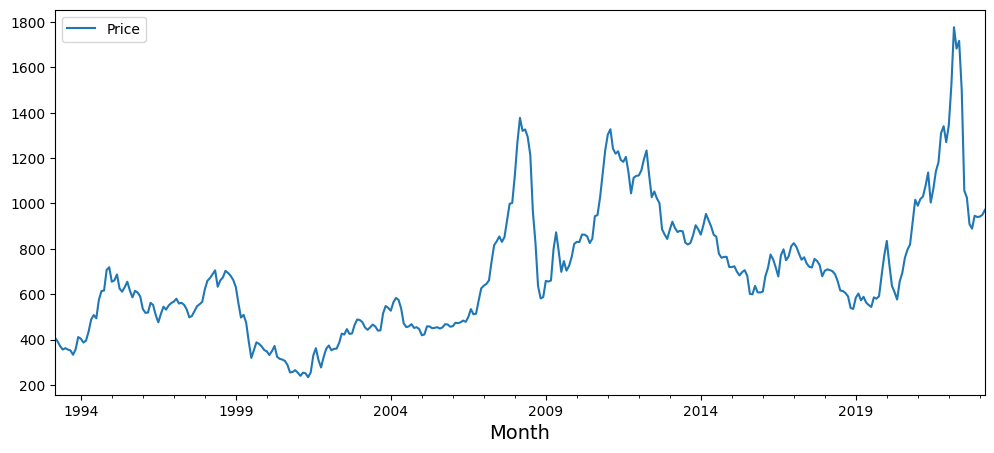

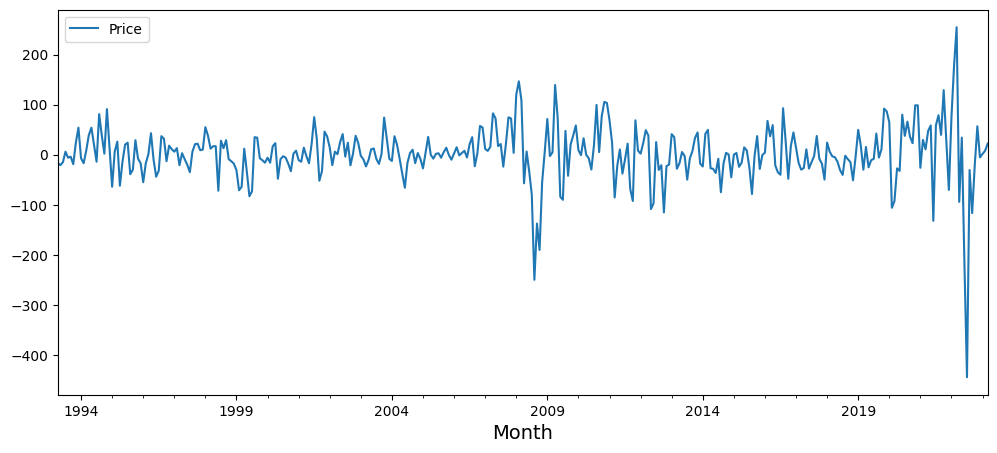

In [53]:
# plt.rcParams["figure.figsize"] = [16, 4]
df.plot()
life_diff = df.diff().dropna()
life_diff.plot()

In [54]:
#Checking for stationarity
check_stationarity(life_diff)

'Stationary	 p-value:2.4432579033101085e-05 	 lags:15


('Stationary', 2.4432579033101085e-05)

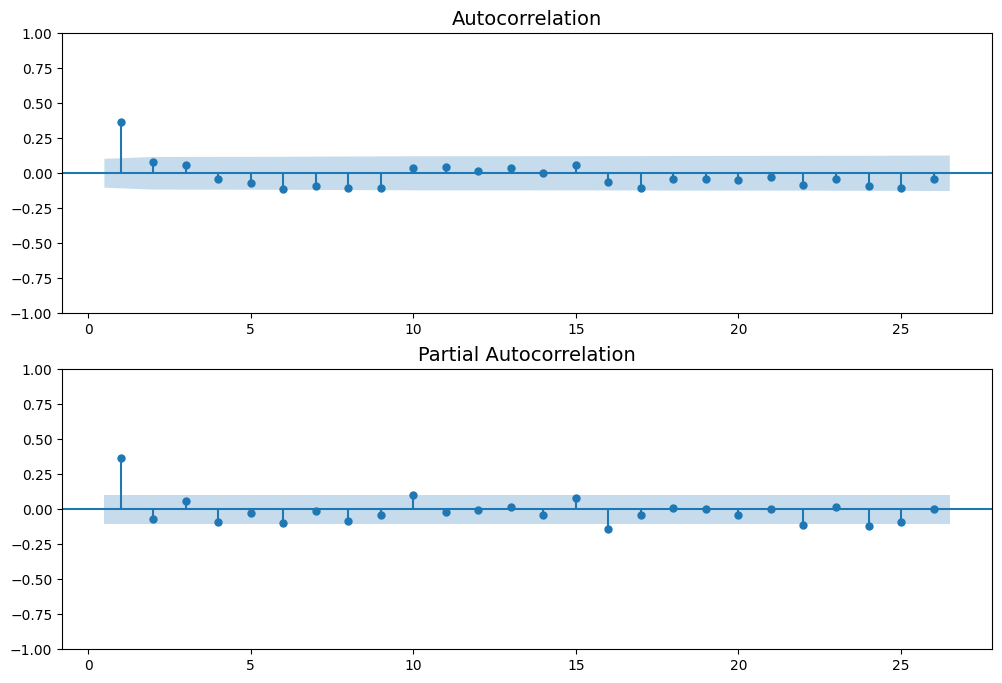

In [55]:
#Plotting the autocorrelation
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()

<Axes: xlabel='Month'>

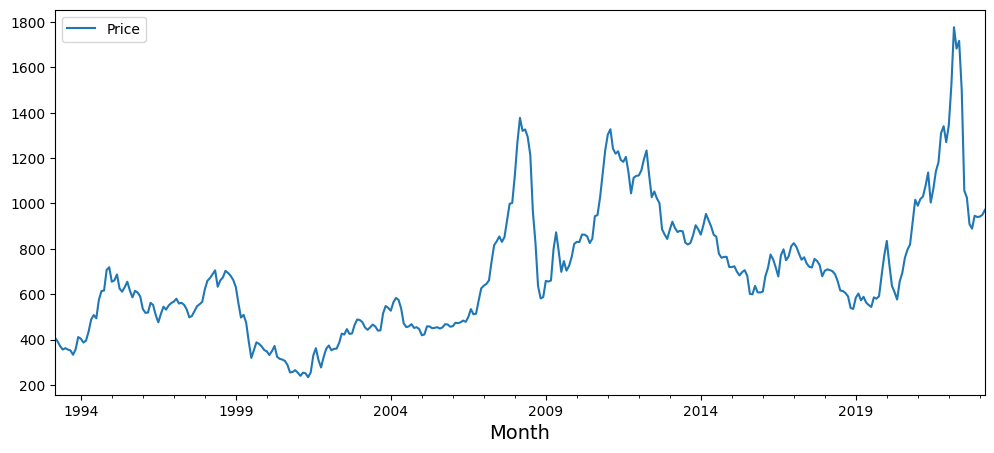

In [56]:
df.plot()

In [57]:
df_diff_12 = df.diff(12).dropna()

In [58]:
check_stationarity(df_diff_12)

'Stationary	 p-value:5.3145752032489796e-05 	 lags:15


('Stationary', 5.3145752032489796e-05)

In [59]:
df_diff_12_1 = df.diff(12).diff(1).dropna()
check_stationarity(df_diff_12_1)

'Stationary	 p-value:3.443011248419225e-06 	 lags:13


('Stationary', 3.443011248419225e-06)

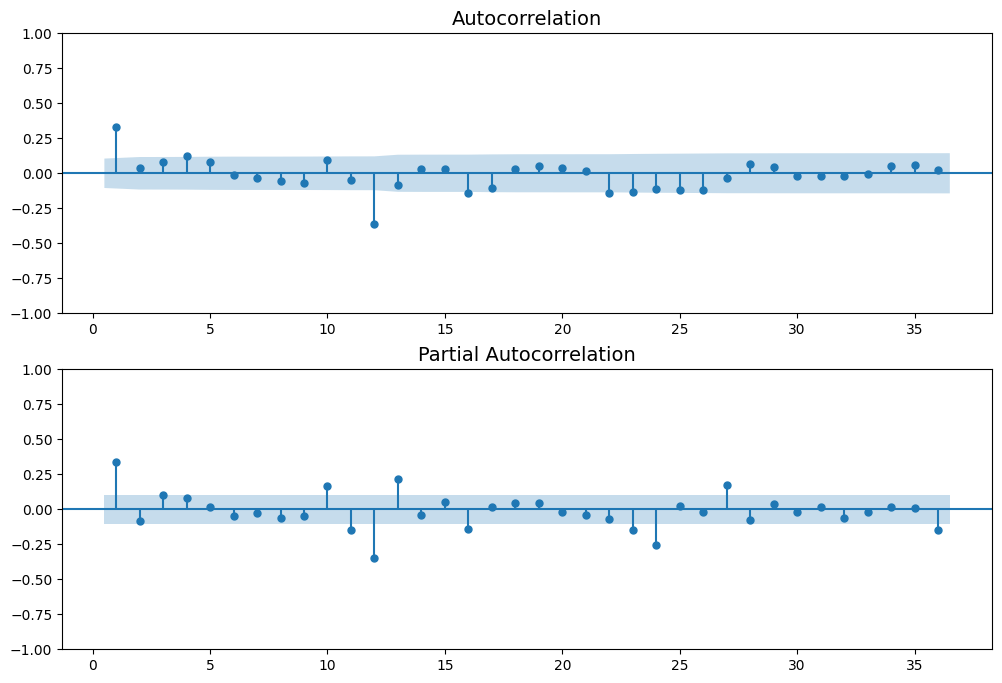

In [60]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(df_diff_12_1, zero=False, ax=ax[1], lags=36)
plt.show()

###SARIMAX Model

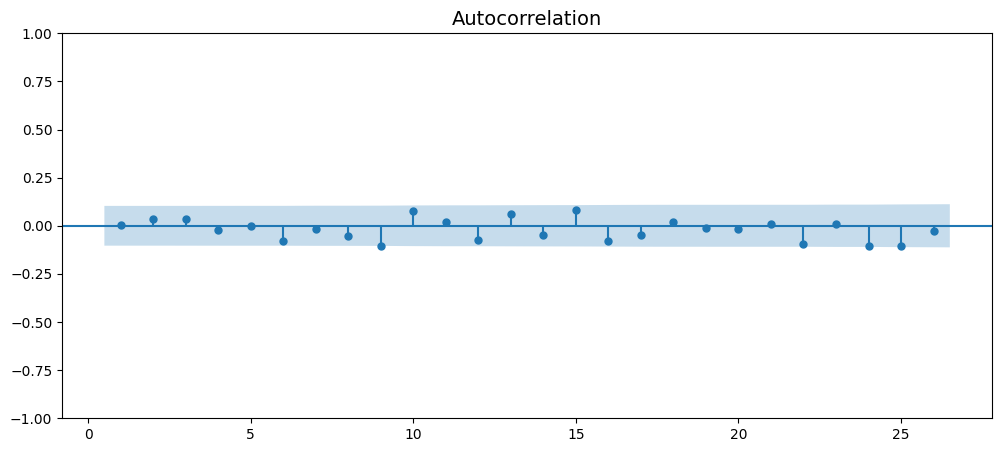

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()

<Axes: xlabel='Month'>

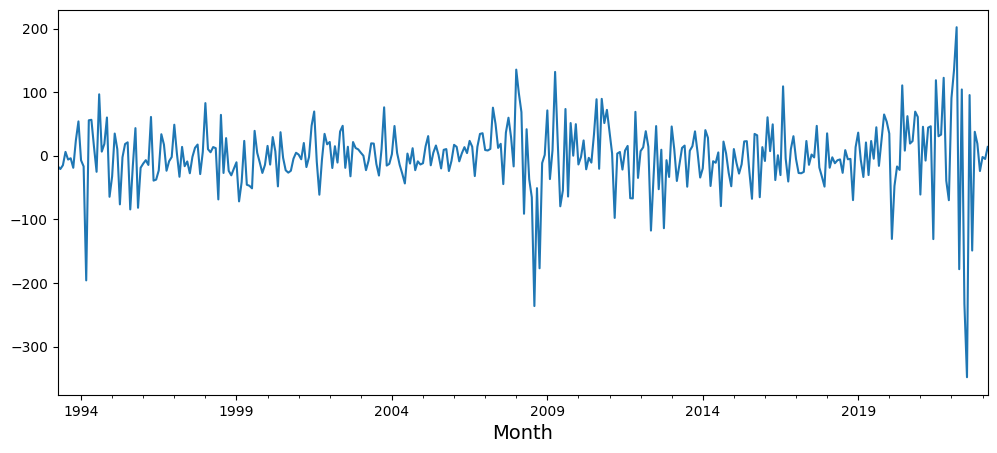

In [62]:
#Plot the residual
model.resid[1:].plot()

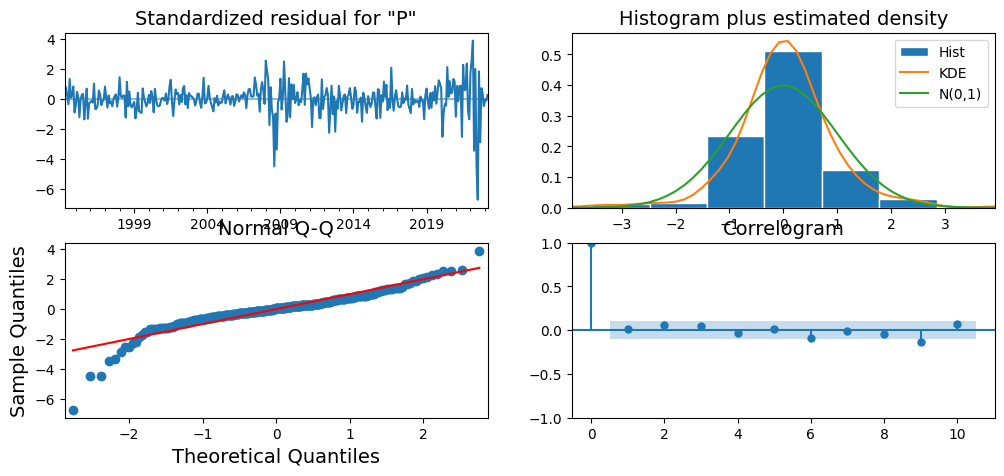

In [63]:
#Plotting the model diagnostics
model.plot_diagnostics();

In [64]:
model.resid[1:]

Month
1993-04-01   -16.397247
1993-05-01   -20.968163
1993-06-01   -14.959288
1993-07-01     6.029045
1993-08-01    -6.011706
                ...    
2022-11-01    18.975018
2022-12-01   -24.028488
2023-01-01    -2.011380
2023-02-01    -5.116410
2023-03-01    13.828565
Length: 360, dtype: float64